In [2]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import glob
import pylab as pl
import numpy as np
import matplotlib.animation as animation
import types
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
import matplotlib.patches as patches
% matplotlib inline

In [3]:
nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/min_ice/nasaRun/Y*2008*.nc'))#*_ptrc_T*.nc'))
print("found *.nc file: \n{}".format(nc_filename))
ptrc=nc.Dataset(nc_filename[0])

uvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridU_19692008.nc')

vvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridV_19692008.nc')

wvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridW_19692008.nc')

found *.nc file: 
['/ocean/xiaoxiny/research/result_jasper/min_ice/nasaRun/Y19682008.nc']


In [4]:
lonNEMO=ptrc.variables['nav_lon'][:,:]
latNEMO=ptrc.variables['nav_lat'][:,:]
dep = ptrc.variables['deptht'][:]


tmask=nc.Dataset(
        '/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/crop.nc')
mbathy=tmask.variables['mbathy'][0,400:,:]
tmask=tmask.variables['tmask'][0,:,400:,:]


bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry'][400:,:]



In [5]:
def vel(keyword,T,ENG):
    'design to obtain velocity field'
    if keyword =='U':
        nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*U*%s*.nc'%(ENG,T)))
        uvel=nc.Dataset(nc_filename[0])        
        data =uvel.variables['vozocrtx'][0,:,400:,:]
    else:
        nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*V*%s*.nc'%(ENG,T)))
        vvel=nc.Dataset(nc_filename[0])
        data =vvel.variables['vomecrty'][0,:,400:,:]
    data =np.ma.masked_where(tmask==0,data)
    return data


def windvel(keyword,T,ENG):
    'design to obtain velocity field'
    if keyword =='U':
        nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*U*%s*.nc'%(ENG,T)))
        uvel=nc.Dataset(nc_filename[0])
        data =uvel.variables['sozotaux'][0,400:,:]
    else:
        nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*V*%s*.nc'%(ENG,T)))
        vvel=nc.Dataset(nc_filename[0])
        data =vvel.variables['sometauy'][0,400:,:]
    data =np.ma.masked_where(tmask[0,:,:]==0,data)
    return data

In [6]:
layer=35
k=0
lon=ptrc.variables['nav_lon'][:,:]
lat=ptrc.variables['nav_lat'][:,:]
x1d=np.linspace(0,lon[:,0].shape[0],lon[:,0].shape[0])
y1d=np.linspace(0,lon[0,:].shape[0],lon[0,:].shape[0])
x2d,y2d=np.meshgrid(y1d,x1d)

In [21]:
def cal_curl(yearnum,startyear,ENG):
    velcurl=[]
    windcurl=[]
    Fram_flux=[]
    Ber_flux=[]
    Bsea_flux=[]
    year=[]
    u15=[]
    u25=[]
    u30=[]
    for time in range (yearnum):
        dx = 1 # meters calculated from the 0.25 degree spatial gridding 
        dy = 1 # meters calculated from the 0.25 degree spatial gridding 
        layer=0

        # vel curl
        u =vel('U',time+startyear,ENG)
        v =vel('V',time+startyear,ENG)

        dv_dx, dv_dy = np.gradient(v[layer,:,:], dx,dy)#-v
        du_dx, du_dy = np.gradient(u[layer,:,:], dx,dy)

        curl=dv_dx-du_dy
        velcurl.append(curl[320,180])
        u15.append(u[15,320,180])
        u25.append(u[25,320,180])
        u30.append(u[30,320,180])
        
        
        #Fram flux        
        flux=np.empty(v[1:,-265,310:335].shape)
        for i in range(len(dz)):
            flux[i,:]=v[i+1,-265,310:335]*dx_flux[-265,310:335]*dz[i]
        flux =np.ma.masked_where(flux==0,flux)
        Fram_flux.append(np.sum(flux))

        #Berling flux
        
        flux=np.empty(v[1:,-20,220:250].shape)
        for i in range(len(dz)):
            flux[i,:]=v[i+1,-20,220:250]*dx_flux[-20,220:250]*dz[i]
        flux =np.ma.masked_where(flux==0,flux)
        Ber_flux.append(np.sum(flux))
        
        
        #Barent Sea flux
        flux=np.empty((49,24))
        input_lon,input_lat,input_v,input_u=[],[],[],[]
        for i in range (25):
            input_lon.append(x_lon[-270+2*i,370+2*i])
            input_lat.append(y_lat[-270+2*i,370+2*i])
            input_v.append(v[:,-270+2*i,370+2*i])
            input_u.append(u[:,-270+2*i,370+2*i])
        input_lon=np.array(input_lon)
        input_dx=input_lon[1:]-input_lon[:-1]
        input_v=np.array(input_v)
        input_u=np.array(input_u)
 
        for i in range(len(dz)):
            flux[i,:]=input_v[1:,i+1]*np.cos(45)*input_dx[:]*np.cos(45)*dz[i]\
                     -input_u[1:,i+1]*np.sin(45)*input_dx[:]*np.cos(45)*dz[i]
        flux =np.ma.masked_where(flux==0,flux)
        Bsea_flux.append(np.sum(flux))
        

        #wind curl
        u =windvel('U',time+startyear,ENG)#+20+1949)
        v =windvel('V',time+startyear,ENG)#+20+1949)

        dv_dx, dv_dy = np.gradient(v[:,:], dx,dy)
        du_dx, du_dy = np.gradient(u[:,:], dx,dy)

        curl=dv_dx-du_dy
        windcurl.append(curl[320,180])#curl[85,112])
        
        
        
        
        
        year.append(time+startyear)
        
    return year,windcurl,velcurl,u15,u25,u30,Fram_flux,Bsea_flux,Ber_flux

In [22]:
m = Basemap(projection='npstere',boundinglat=67,lon_0=0,resolution='l',round='TRUE')
x_lon,y_lat = m(lonNEMO,latNEMO)

dx_flux=np.array(x_lon[1:]-x_lon[:-1])
dz=np.array(dep[1:]-dep[:-1])

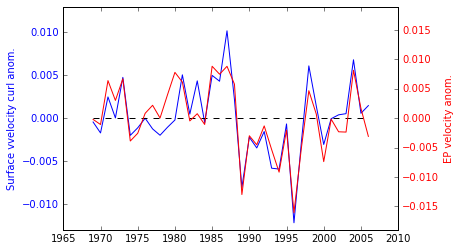

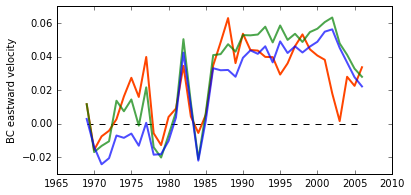

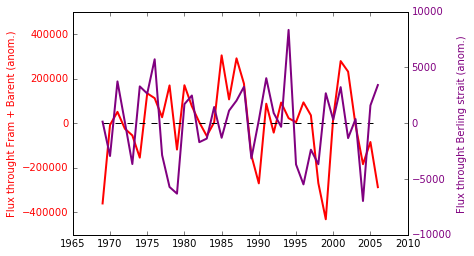

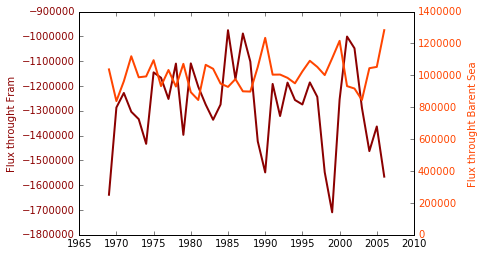

In [73]:
year,windcurl,velcurl,u15,u25,u30,Fram_flux,Bsea_flux,Ber_flux=cal_curl(yearnum=38,startyear=1969,ENG='ENG3')


fig, ax1 = plt.subplots()

ax1.plot(year,velcurl-np.mean(velcurl))
ax1.set_ylabel('Surface vvelocity curl anom.', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
plt.ylim(-0.013,0.013)

ax2 = ax1.twinx()
ax2.plot(year,(0-np.array(windcurl)+np.mean(windcurl))/(2*1e-4*1e3),'r')
ax2.set_ylabel('EP velocity anom.', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.hlines(y=0,xmin=np.min(year),xmax=np.max(year),linestyles='--')
plt.ylim(-0.019,0.019)

plt.show()




fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot()

plt.plot(year,u15,'orangered',lw=2,label=dep[15])
plt.plot(year,u25,'green',lw=2,label=dep[25],alpha=0.7)
plt.plot(year,u30,'blue',lw=2,label=dep[30],alpha=0.7)
plt.hlines(y=0,xmin=np.min(year),xmax=np.max(year),linestyles='--')
plt.ylabel('BC eastward velocity')




fig, ax1 = plt.subplots()
ax1.plot(year,Fram_flux+np.array(Bsea_flux)-np.mean(Fram_flux)-np.array(Bsea_flux),'red',\
         lw=2,label='Fram+Barent anom.')
#ax1.plot(year,Bsea_flux,'b',lw=2,label='Barent')
ax1.set_ylabel('Flux throught Fram + Barent (anom.)' , color='red')
for tl in ax1.get_yticklabels():
    tl.set_color('red')
plt.ylim(-5e5,5e5)
ax2 = ax1.twinx()
ax2.plot(year,Ber_flux-np.mean(Ber_flux),'purple',lw=2,label='Berling')
ax2.set_ylabel('Flux throught Berling strait (anom.)', color='purple')
for tl in ax2.get_yticklabels():
    tl.set_color('purple')
plt.ylim(-1e4,1e4)
ax2.hlines(y=0,xmin=np.min(year),xmax=np.max(year),linestyles='--')
plt.show()



fig, ax1 = plt.subplots()
ax1.plot(year,Fram_flux,'darkred',lw=2,label='Fram+Barent')
#ax1.plot(year,Bsea_flux,'b',lw=2,label='Barent')
ax1.set_ylabel('Flux throught Fram', color='darkred')
for tl in ax1.get_yticklabels():
    tl.set_color('darkred')
#plt.ylim(-5e5,5e5)
ax2 = ax1.twinx()
ax2.plot(year,np.array(Bsea_flux),'orangered',lw=2,label='Berling')
ax2.set_ylabel('Flux throught Barent Sea', color='orangered')
for tl in ax2.get_yticklabels():
    tl.set_color('orangered')
#plt.ylim(-1e4,1e4)
ax2.hlines(y=0,xmin=np.min(year),xmax=np.max(year),linestyles='--')
plt.show()

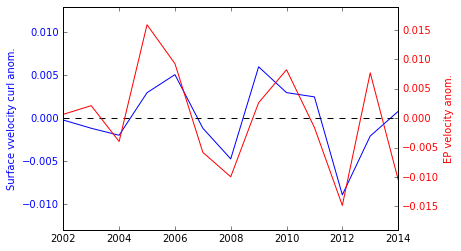

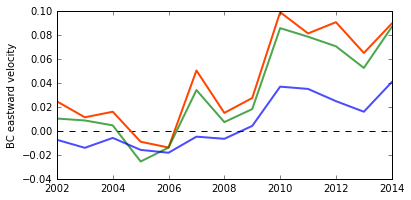

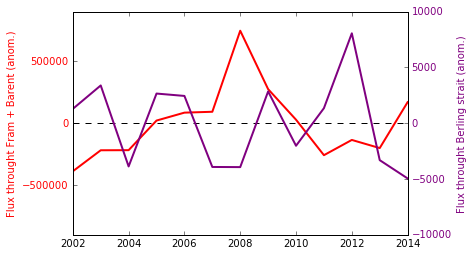

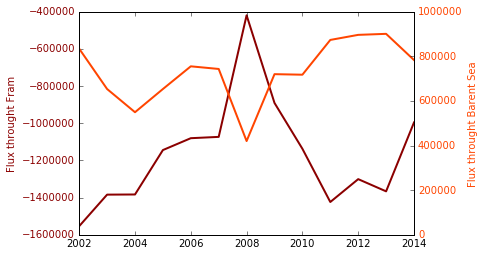

In [71]:
year,windcurl,velcurl,u15,u25,u30,Fram_flux,Bsea_flux,Ber_flux=cal_curl(yearnum=13,startyear=2002,ENG='EXH001')


fig, ax1 = plt.subplots()

ax1.plot(year,velcurl-np.mean(velcurl))
ax1.set_ylabel('Surface vvelocity curl anom.', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
plt.ylim(-0.013,0.013)

ax2 = ax1.twinx()
ax2.plot(year,(0-np.array(windcurl)+np.mean(windcurl))/(2*1e-4*1e3),'r')
ax2.set_ylabel('EP velocity anom.', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.hlines(y=0,xmin=np.min(year),xmax=np.max(year),linestyles='--')
plt.ylim(-0.019,0.019)

plt.show()




fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot()

plt.plot(year,u15,'orangered',lw=2,label=dep[15])
plt.plot(year,u25,'green',lw=2,label=dep[25],alpha=0.7)
plt.plot(year,u30,'blue',lw=2,label=dep[30],alpha=0.7)
plt.hlines(y=0,xmin=np.min(year),xmax=np.max(year),linestyles='--')
plt.ylabel('BC eastward velocity')


fig, ax1 = plt.subplots()
ax1.plot(year,Fram_flux+np.array(Bsea_flux)-np.mean(Fram_flux)-np.array(Bsea_flux),'red'\
         ,lw=2,label='Fram+Barent')
ax1.set_ylabel('Flux throught Fram + Barent (anom.)', color='red')
for tl in ax1.get_yticklabels():
    tl.set_color('red')
plt.ylim(-9e5,9e5)
ax2 = ax1.twinx()
ax2.plot(year,Ber_flux-np.mean(Ber_flux),'purple',lw=2,label='Berling')
ax2.set_ylabel('Flux throught Berling strait (anom.)', color='purple')
for tl in ax2.get_yticklabels():
    tl.set_color('purple')
plt.ylim(-1e4,1e4)
ax2.hlines(y=0,xmin=np.min(year),xmax=np.max(year),linestyles='--')
plt.show()


fig, ax1 = plt.subplots()
ax1.plot(year,Fram_flux,'darkred',lw=2,label='Fram+Barent')
#ax1.plot(year,Bsea_flux,'b',lw=2,label='Barent')
ax1.set_ylabel('Flux throught Fram', color='darkred')
for tl in ax1.get_yticklabels():
    tl.set_color('darkred')
#plt.ylim(-5e5,5e5)
ax2 = ax1.twinx()
ax2.plot(year,np.array(Bsea_flux),'orangered',lw=2,label='Berling')
ax2.set_ylabel('Flux throught Barent Sea', color='orangered')
for tl in ax2.get_yticklabels():
    tl.set_color('orangered')
#plt.ylim(-1e4,1e4)
ax2.hlines(y=0,xmin=np.min(year),xmax=np.max(year),linestyles='--')
plt.show()



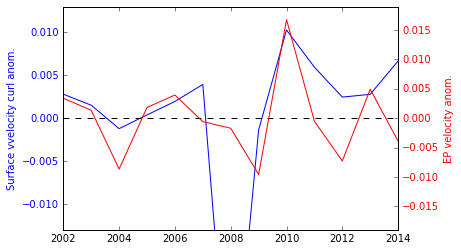

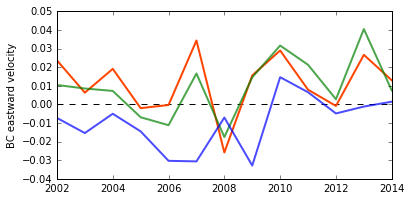

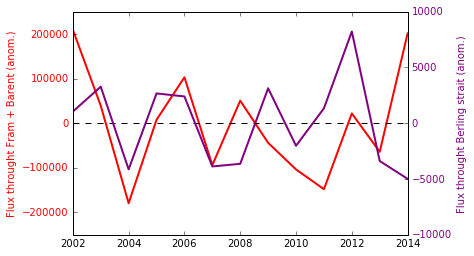

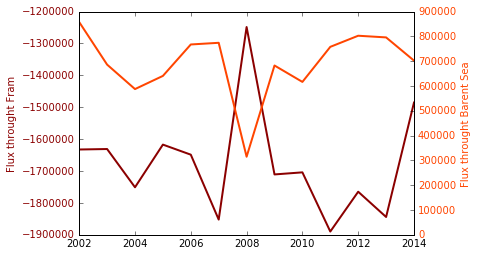

In [72]:
year,windcurl,velcurl,u15,u25,u30,Fram_flux,Bsea_flux,Ber_flux=cal_curl(yearnum=13,startyear=2002,ENG='EXH005')


fig, ax1 = plt.subplots()

ax1.plot(year,velcurl-np.mean(velcurl))
ax1.set_ylabel('Surface vvelocity curl anom.', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
plt.ylim(-0.013,0.013)

ax2 = ax1.twinx()
ax2.plot(year,(0-np.array(windcurl)+np.mean(windcurl))/(2*1e-4*1e3),'r')
ax2.set_ylabel('EP velocity anom.', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.hlines(y=0,xmin=np.min(year),xmax=np.max(year),linestyles='--')
plt.ylim(-0.019,0.019)

plt.show()


fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot()

plt.plot(year,u15,'orangered',lw=2,label=dep[15])
plt.plot(year,u25,'green',lw=2,label=dep[25],alpha=0.7)
plt.plot(year,u30,'blue',lw=2,label=dep[30],alpha=0.7)
plt.hlines(y=0,xmin=np.min(year),xmax=np.max(year),linestyles='--')
plt.ylabel('BC eastward velocity')


fig, ax1 = plt.subplots()
ax1.plot(year,Fram_flux+np.array(Bsea_flux)-np.mean(Fram_flux)-np.mean(Bsea_flux),'red'\
         ,lw=2,label='Fram+Barent')
ax1.set_ylabel('Flux throught Fram + Barent (anom.)', color='red')
for tl in ax1.get_yticklabels():
    tl.set_color('red')
plt.ylim(-2.5e5,2.5e5)
ax2 = ax1.twinx()
ax2.plot(year,Ber_flux-np.mean(Ber_flux),'purple',lw=2,label='Berling')
ax2.set_ylabel('Flux throught Berling strait (anom.)', color='purple')
for tl in ax2.get_yticklabels():
    tl.set_color('purple')
plt.ylim(-1e4,1e4)
ax2.hlines(y=0,xmin=np.min(year),xmax=np.max(year),linestyles='--')
plt.show()


fig, ax1 = plt.subplots()
ax1.plot(year,Fram_flux,'darkred',lw=2,label='Fram+Barent')
#ax1.plot(year,Bsea_flux,'b',lw=2,label='Barent')
ax1.set_ylabel('Flux throught Fram', color='darkred')
for tl in ax1.get_yticklabels():
    tl.set_color('darkred')
#plt.ylim(-5e5,5e5)
ax2 = ax1.twinx()
ax2.plot(year,np.array(Bsea_flux),'orangered',lw=2,label='Berling')
ax2.set_ylabel('Flux throught Barent Sea', color='orangered')
for tl in ax2.get_yticklabels():
    tl.set_color('orangered')
#plt.ylim(-1e4,1e4)
ax2.hlines(y=0,xmin=np.min(year),xmax=np.max(year),linestyles='--')
plt.show()



# Just test below

In [311]:
dx = 28400.0 # meters calculated from the 0.25 degree spatial gridding 
dy = 28400.0 # meters calculated from the 0.25 degree spatial gridding 
time=30;layer=0

u =vel('U',time)
v =vel('V',time)

#u =np.ma.masked_where(abs(V)>0.1,U)
#v =np.ma.masked_where(abs(V)>0.1,V)
#u =np.ma.masked_where(abs(U)>0.1,u)
#v =np.ma.masked_where(abs(U)>0.1,v)
    
dv_dx, dv_dy = np.gradient(v[layer,:,:], dx,dy)
du_dx, du_dy = np.gradient(u[layer,:,:], dx,dy)

curl=dv_dx-du_dy

<matplotlib.colorbar.Colorbar instance at 0x7f413c3f4638>

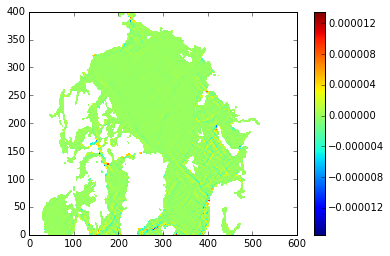

In [313]:
plt.pcolor(curl)
plt.colorbar()

(400, 544)


<matplotlib.colorbar.Colorbar instance at 0x7f413c6983f8>

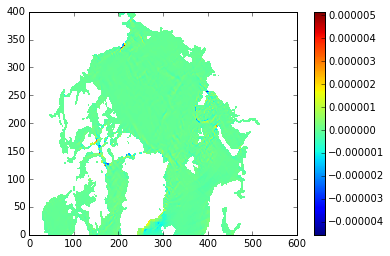

In [314]:
time=20
u =windvel('U',time)
v =windvel('V',time)
print u.shape

#u =np.ma.masked_where(abs(V)>0.1,U)
#v =np.ma.masked_where(abs(V)>0.1,V)
#u =np.ma.masked_where(abs(U)>0.1,u)
#v =np.ma.masked_where(abs(U)>0.1,v)
    
dv_dx, dv_dy = np.gradient(v[:,:], dx,dy)
du_dx, du_dy = np.gradient(u[:,:], dx,dy)

curl=dv_dx-du_dy


# wind 
plt.pcolor(curl)
plt.colorbar()

In [315]:
velcurl=[]
windcurl=[]
year=[]
u15=[]
u25=[]
u30=[]
for time in range (38):
    dx = 1 # meters calculated from the 0.25 degree spatial gridding 
    dy = 1 # meters calculated from the 0.25 degree spatial gridding 
    layer=0

    u =vel('U',time)
    v =vel('V',time)

    #u =np.ma.masked_where(abs(V)>0.1,U)
    #v =np.ma.masked_where(abs(V)>0.1,V)
    #u =np.ma.masked_where(abs(U)>0.1,u)
    #v =np.ma.masked_where(abs(U)>0.1,v)

    dv_dx, dv_dy = np.gradient(v[layer,:,:], dx,dy)#-v
    du_dx, du_dy = np.gradient(u[layer,:,:], dx,dy)

    curl=dv_dx-du_dy
    velcurl.append(curl[320,180])
    u15.append(u[15,320,180])
    u25.append(u[25,320,180])
    u30.append(u[30,320,180])
    
    
    u =windvel('U',time)#+20+1949)
    v =windvel('V',time)#+20+1949)

    #u =np.ma.masked_where(abs(V)>0.1,U)
    #v =np.ma.masked_where(abs(V)>0.1,V)
    #u =np.ma.masked_where(abs(U)>0.1,u)
    #v =np.ma.masked_where(abs(U)>0.1,v)

    dv_dx, dv_dy = np.gradient(v[:,:], dx,dy)
    du_dx, du_dy = np.gradient(u[:,:], dx,dy)

    curl=dv_dx-du_dy
    windcurl.append(curl[320,180])#curl[85,112])
    year.append(time+1969)

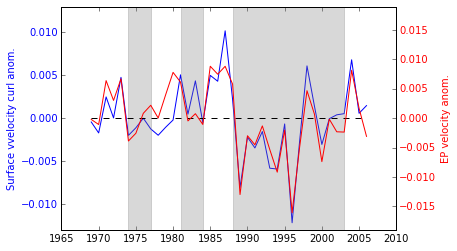

In [318]:

fig, ax1 = plt.subplots()

ax1.plot(year,velcurl-np.mean(velcurl))
#ax1.set_xlabel('time (year)')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Surface vvelocity curl anom.', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
plt.ylim(-0.013,0.013)

ax2 = ax1.twinx()
ax2.plot(year,(0-np.array(windcurl)+np.mean(windcurl))/(2*1e-4*1e3),'r')
ax2.set_ylabel('EP velocity anom.', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.hlines(y=0,xmin=np.min(year),xmax=np.max(year),linestyles='--')
plt.ylim(-0.019,0.019)



#ax2 = ax1.twinx()
#ax2.plot(year,np.array(u15),'gold',label=dep[15],lw=2)
#ax2.plot(year,u25,'green',label=dep[25],lw=2)
#ax2.plot(year,u30,'darkgreen',label=dep[30],lw=2)
#for tl in ax2.get_yticklabels():
#    tl.set_color('w')
#ax2.hlines(y=0,xmin=np.min(year),xmax=np.max(year),linestyles='--')
#plt.ylim(-0.07,0.07)

plt.axvspan(1988, 2003, alpha=0.3, color='grey')
plt.axvspan(1981, 1984, alpha=0.3, color='grey')
plt.axvspan(1974, 1977, alpha=0.3, color='grey')

plt.show()

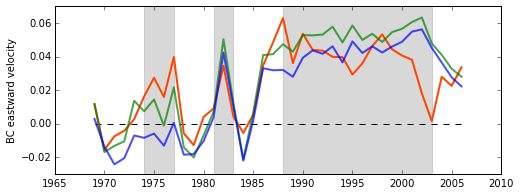

In [320]:
fig = plt.figure(figsize=(8,3))
ax1 = fig.add_subplot()

plt.plot(year,u15,'orangered',lw=2,label=dep[15])
plt.plot(year,u25,'green',lw=2,label=dep[25],alpha=0.7)
plt.plot(year,u30,'blue',lw=2,label=dep[30],alpha=0.7)
plt.hlines(y=0,xmin=np.min(year),xmax=np.max(year),linestyles='--')
plt.ylabel('BC eastward velocity')

plt.axvspan(1988, 2003, alpha=0.3, color='grey')
plt.axvspan(1981, 1983, alpha=0.3, color='grey')
plt.axvspan(1974, 1977, alpha=0.3, color='grey')


#plt.legend()

In [92]:
uvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_core2/u10_core2_y1948.nc')
print uvel.variables
vvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_core2/v10_core2_y1948.nc')
lon=uvel.variables['LON'][:]
lat=uvel.variables['LAT'][:]
lon,lat=np.meshgrid(lon,lat)

OrderedDict([(u'LAT', <netCDF4.Variable object at 0x7f4171ce0b00>), (u'LON', <netCDF4.Variable object at 0x7f4171ce0df8>), (u'TIME', <netCDF4.Variable object at 0x7f4171ce0f28>), (u'TIME_bnds', <netCDF4.Variable object at 0x7f4154063cc8>), (u'u10', <netCDF4.Variable object at 0x7f4154063b00>)])


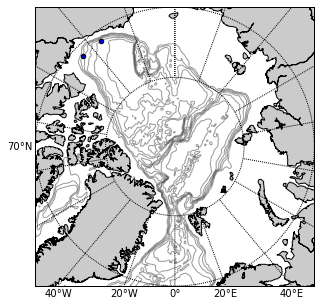

In [76]:
fig = plt.figure(figsize=(5,5))

time =20+1948
ax = fig.add_subplot()
m = Basemap(projection='npstere',boundinglat=70,lon_0=0,resolution='l')
m.drawcoastlines()
m.fillcontinents(color = '0.75',alpha=0.8)
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
x_lon,y_lat = m(lon,lat)
x_lonNEMO,y_latNEMO = m(lonNEMO,latNEMO)
m.scatter(x_lonNEMO[320,180],y_latNEMO[320,180])
m.scatter(x_lonNEMO[300,155],y_latNEMO[300,155])
m.scatter(x_lon[84,115],y_lat[84,115],color='r')
m.contour(x_lonNEMO,y_latNEMO,bathy,linewidth=0.075,colors='black',alpha=0.4)
